# Kernel regressions

Kernel regression is a technique for non-parametric estimation of regression models, this means that the method does not make assumptions about the distribution of the data. Unlike linear regression, which estimates a single constant coefficient for each predictor variable, kernel regression estimates a smooth function of the predictor variables. It does it through the kernel, which is a function that determines how similar two points are and estimates new values based on the values from nearby points. This makes it well suited for data sets where the underlying relationship between the dependent and independent variables is non-linear. This method can be applied to curve fitting, prediction, classification, and density estimation. It is also well-suited for data with discontinuities or nonlinear structure. In general, any situation where you need to estimate an unknown function from data can benefit from using kernel regression. There exist several methods, some of them are listed below.

## Overview

We will explore representative examples of the Gaussian kernel (also called radial basis function, rbf) for regression applications using 1D and multi-dimensional data.

# Libraries

In [1]:
import numpy   as np
import pandas  as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats             import norm
from scipy.stats             import multivariate_normal

from sklearn.kernel_ridge    import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics         import mean_squared_error

blue   = '#0021A5'
orange = '#FA4616'

## 1. Kernels in linear regressions

Before we get started, let's do a brief reminder of what we know so far about a linear regression

In [2]:
# Create a function to help us plot
def show_plot(x, y, x2=None, y2=None):

    plt.xlabel('x')
    plt.ylabel('y')

    plt.scatter(x, y, color=blue)

    if (x2 is not None) and (y2 is not None):
        plt.plot(x2, y2, c=orange, lw=4)
    
    plt.show()

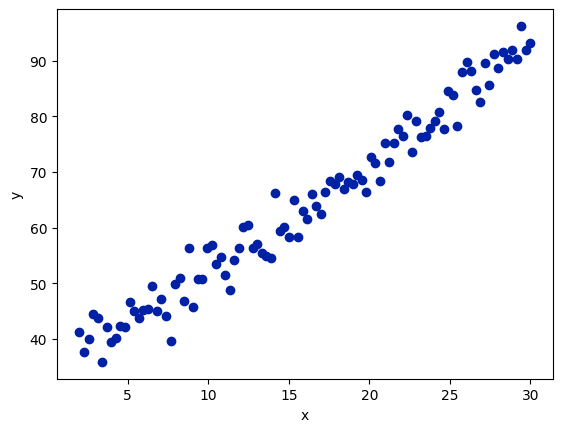

In [3]:
# Define seed for reproducibility
np.random.seed(0)

# Generate a random quasi-linear dataset
x = np.linspace(2.0, 30.0, num=100)

y = 2.0*(x + 15.0) + 3.0*np.random.randn(x.size) + 2.0

show_plot(x, y)

We already know that a solution can be obtained for $\mathbf{X} \in \mathbb{R}^{n \times 2}$, and $\mathbf{y} \in \mathbb{R}^n$ by means of the normal equation, in the form
$$
\beta = (\mathbf{X}^\mathrm{T}\, \mathbf{X})^{-1}\, \mathbf{X}^\mathrm{T}\, \mathbf{Y}
$$

We also know how to solve this problem analytically

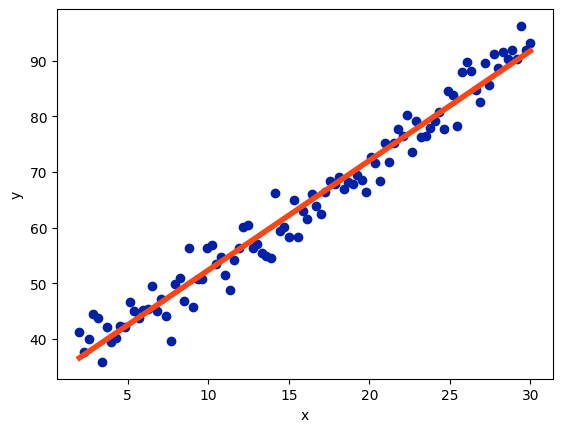

In [4]:
# Solve data using the primal expression
def primal_expression(x, y, plot=True, return_B=False):

    X = np.stack( [np.ones(x.size), x], axis=1 ).reshape(-1, 2)
    Y = y[:,np.newaxis]

    X_T_times_X_inv             = np.linalg.inv( np.matmul(X.T, X) )
    X_T_times_X_inv_product_X_T = np.matmul(X_T_times_X_inv, X.T)

    B = np.matmul(X_T_times_X_inv_product_X_T, Y)
    H = np.matmul(X, X_T_times_X_inv_product_X_T)

    y_predicted = np.matmul(H, Y).reshape(-1)

    if plot:
        show_plot(x, y, x2=x, y2=y_predicted)

    if return_B:
        return B

primal_expression(x, y)

Note, however, that we assumed the existence of $(\mathbf{X}^\mathrm{T}\, \mathbf{X})^{-1}$, although sometimes we can run into numerical trouble computing the inverse matrix. We can avoid it by adding a small value, $\lambda\, \mathbf{I},$ to the matrix product before calculating the inverse. This is known as the **Ridge regression**,
$$
\beta = (\mathbf{X}^\mathrm{T}\, \mathbf{X} + \lambda\, \mathbf{I})^{-1}\, \mathbf{X}^\mathrm{T}\, \mathbf{Y},
$$
where $\mathbf{I}$ is the identity matrix. If we look close at the dimensions for $\mathbf{X}^\mathrm{T}$ we get
$$
\beta = (\underbrace{\mathbf{X}^\mathrm{T}\, \mathbf{X}}_{\mathbb{R}^{2 \times n}\, \mathbb{R}^{n \times 2} = \mathbb{R}^{2 \times 2}} + \lambda\, \mathbf{I})^{-1}\, \mathbf{X}^\mathrm{T}\, \mathbf{Y}
$$
This expression is known as the *primal* form. If instead of $\mathbf{X}^\mathrm{T}\, \mathbf{X}$ we use $\mathbf{X}\, \mathbf{X}^\mathrm{T}$ and rearrange the expression we have
$$
\beta = \mathbf{X}^\mathrm{T}\, (\underbrace{\mathbf{X}\, \mathbf{X}^\mathrm{T}}_{\mathbb{R}^{n \times 2}\, \mathbb{R}^{2 \times n} = \mathbb{R}^{n \times n}} + \lambda\, \mathbf{I})^{-1}\, \mathbf{Y}
$$
We arrive at the *dual* form of the equation. Notice that now the product $\mathbf{X}\, \mathbf{X}^\mathrm{T}$ results in a square matrix with dimension $n \times n$. Computing this matrix is more expensive compared to the product $\mathbf{X}^\mathrm{T}\, \mathbf{X}$ with dimension $2 \times 2$, but the *dual* form is more useful for classification problems.

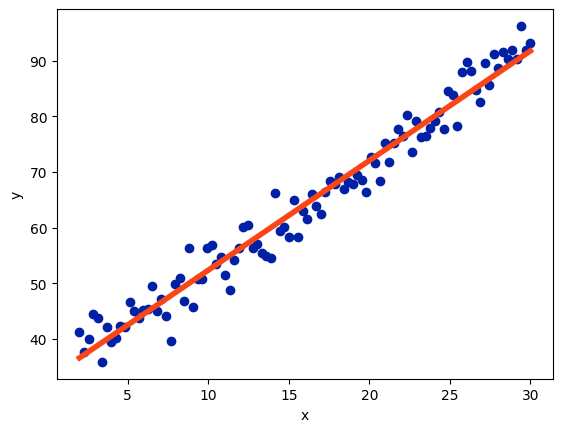

In [5]:
def dual_expression(x,y, plot=True, regularization=1e-10, return_B=False):

    X = np.stack( [np.ones(x.size), x], axis=1 ).reshape(-1, 2)
    Y = y[:,np.newaxis]
    
    X_times_X_T_inv             = np.linalg.inv( np.matmul(X, X.T) + regularization*np.identity(x.size))
    X_T_product_X_times_X_T_inv = np.matmul(X.T, X_times_X_T_inv)

    B = np.matmul(X_T_product_X_times_X_T_inv, Y)
    H = np.matmul(X, X_T_product_X_times_X_T_inv)

    y_predicted = np.matmul(H, Y).reshape(-1)

    if plot:
        show_plot(x, y, x2=x, y2=y_predicted)
        
    if return_B:
        return B

dual_expression(x, y, regularization=1e-6)

Note that the regularization parameter is used to avoid singular matrices. In this case, we are using a very small value, but in practice, it is recommended to use a value between 1e-3 and 1e-6. Also notice that the dual expression depends on the magnitude of the regularization parameter $\lambda$

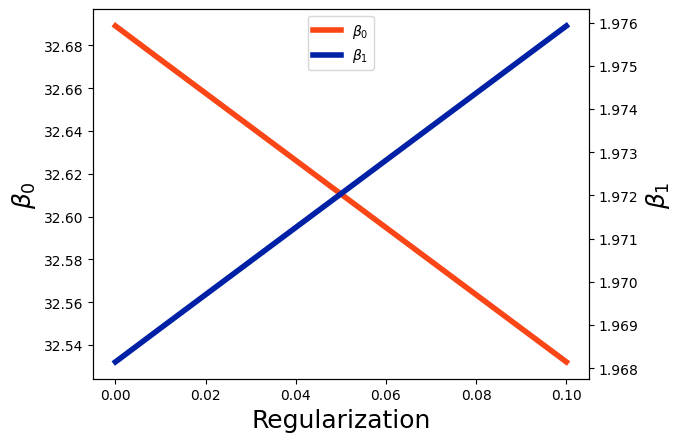

In [6]:
exponents       = np.arange(start=-5.0, stop=0.0, step=1.0)
regularizations = np.power(10.0, exponents)

betas = np.array([dual_expression(x, y, regularization=i,
                                  plot=False, return_B=True) for i in regularizations])

fig, ax1 = plt.subplots()

ax1.set_xlabel('Regularization', fontsize=18)
ax1.set_ylabel(r'$\beta_0$', fontsize=18)

ax2 = ax1.twinx()
ax2.set_ylabel(r'$\beta_1$', fontsize=18)

lns1 = ax1.plot(regularizations, betas[:,0], c=orange, lw=4, label=r'$\beta_0$')
lns2 = ax2.plot(regularizations, betas[:,1], c=blue,   lw=4, label=r'$\beta_1$')

lines = lns1+lns2
label = [line.get_label() for line in lines]

plt.legend(lines, label, loc='upper center')
plt.show()

Let's compare the time it takes to get the regression using both expression

In [7]:
%timeit -n 1000 primal_expression(x,y, plot=False)

%timeit -n 1000 dual_expression(x,y, plot=False)

105 μs ± 48.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
876 μs ± 73.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Data, however, is often not linear. If we add at least another dimension to our data, we might be able to fit a linear model to it. This is the idea behind the kernel trick. We can add a new dimension to our data, and then project it back to the original space using a kernel function. This is a very powerful idea, and it allows us to fit non-linear data using linear models. For that we need to define a transformation by means of a kernel function with the general form
$$
k(x_i, x_j) = \phi(x_i)\, \phi(x_j).
$$
Now we replace the matrix product from our dual form for linear regression with the kernel functions,
$$
\hat{k}(z)\, \mathbf{K}\, y = y(z),
$$
where
$$
K_{i,j} = k(x_i,x_j),
$$
$$
\hat{k}(z) =
\begin{bmatrix}
  k(z, x_0) \\
  k(z, x_1) \\
  \vdots    \\
  k(z,x_n)  \\
\end{bmatrix}
$$
Notice that we are embedding a vector $z$ for the evaluating the regression. Let's start the implementation with the kernel

In [8]:
def kernel(xi, xj, choice='linear', width=0.5):
        
    if choice in ('g', 'gauss'):
        return np.exp( -width*np.linalg.norm(xi - xj) )
    
    else:
        return np.dot(xj, xi)

Now we generate a random dataset with a non-linear relationship between x and y

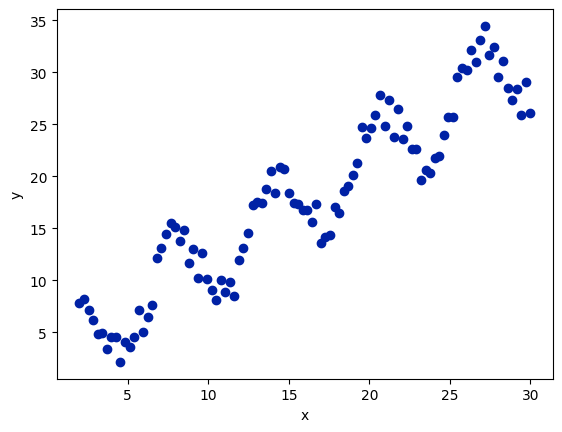

In [9]:
# Generate seed for reproducibility
np.random.seed(0)

# let's set up some non linear data
y = x + 4.0*np.sin(x)+ 4.0*np.random.rand(x.size)

show_plot(x, y)

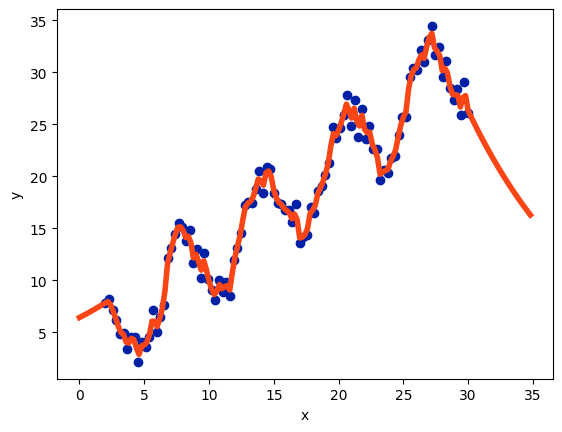

In [10]:
# Define a function for the kernel-based regression
def kernel_regression(x, y, z, choice='linear', regularization=0.1, width=1):
    
    X = np.stack( [np.ones(x.size), x], axis=1 ).reshape(-1, 2)
    Z = np.stack([np.ones(z.size), z], axis=1)

    K = np.array([ [kernel(X[i], X[j], choice='g', width=width)
                    for j in range(x.size) ]
                    for i in range(x.size) ])

    K_inv = np.linalg.inv(K + regularization*np.identity(x.size))

    K_inv_times_y = np.matmul(K_inv, y)

    y_pred = np.zeros(z.size)

    for idx, z0 in enumerate(Z):

        k = [ kernel(z0, xi, choice=choice, width=width) for xi in X ]

        y_pred[idx] = np.matmul(k, K_inv_times_y)

    return y_pred

# Generate a set of points for prediction
z = np.arange(0, 35, 0.2)

y_pred = kernel_regression(x, y, z, choice='g', regularization=1e-2, width=0.1)

show_plot(x, y, x2=z.reshape(-1), y2=y_pred)

Notice that there are two **hyperparameters** in the kernel-based regression, namely the regularization parameter, $\lambda$ and the width for the kernel. Considering the RMSE as a metric to evaluate the performance of the model, now we need to select the best choice for $\lambda$ and the width for the kernel. For that, we can use a grid search

In [11]:
def grid_search_kernel_regression(x, y, split=0.8, widths=None, regularizations=None):
    results = []

    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=split, random_state=0)
    
    for width in widths:
        for regularization in regularizations:
            
            y_pred = kernel_regression(x_train, y_train, x_test, choice='g', regularization=regularization, width=width)
            
            rmse   = np.sqrt( mean_squared_error(y_test, y_pred) )
            
            results.append({'Width': width, 'Regularization': regularization, 'RMSE': rmse})
    
    df_results = pd.DataFrame(results)
    df_pivot = df_results.pivot(index='Width', columns='Regularization', values='RMSE')

    return df_pivot
    
# Call the function with x and y
widths          = np.linspace(0.01, 1.0, num=20)
regularizations = np.linspace(1e-6, 1.0, num=20)

dataframe = grid_search_kernel_regression(x, y, widths=widths, regularizations=regularizations)

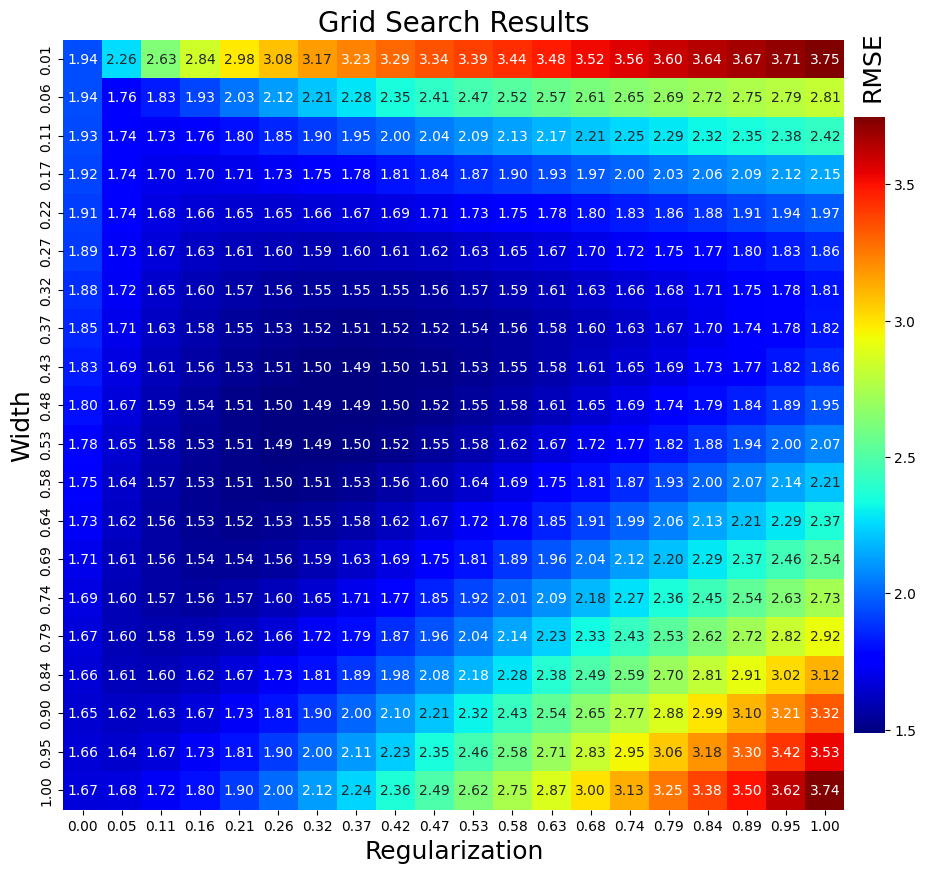

In [12]:
# Plot a heatmap with the results
fig, ax = plt.subplots(figsize=(12, 10))

ax.set_title('Grid Search Results', size=20)

ax.set_xlabel('Regularization', size=18)
ax.set_ylabel('Gaussian width', size=18)

sns.heatmap(dataframe, ax=ax, annot=True, fmt='.2f',
            cmap='jet', cbar=True,
            cbar_kws={'pad':0.01, 'shrink':0.8},

            xticklabels=[f'{i:.2f}' for i in regularizations],
            yticklabels=[f'{i:.2f}' for i in widths])

cbar = ax.collections[0].colorbar

cbar.ax.set_title(f"RMSE", x=0.6, y=1.02, size=18, rotation=90)

plt.show()

After inspecting a heatmap with size $20 \times 20$, we can see that the best results are obtained with a width of 0.48 and a regularization of 0.32. With this information, we can now plot the final results.

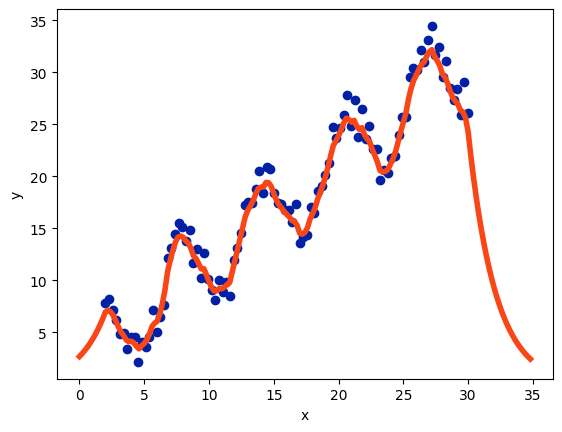

In [13]:
z = np.arange(0, 35, 0.2)

y_pred = kernel_regression(x, y, z, choice='g', regularization=0.32, width=0.48)

show_plot(x, y, x2=z.reshape(-1), y2=y_pred)

Now that we know how kernels can help us do machine learning on non-linear data, let's have a closer look at the kernel itself. In the previous example, we used a Gaussian kernel, so we will start by looking at it.

## 2. Gaussian kernel regression

In Gaussian kernel regression the shape of the kernel is the Gaussian curve:
$$
\frac{1}{\sqrt{2\,\pi}} \exp \left[ - \frac{z^2}{2} \right].
$$

Each constructed kernel describes a normal distribution with mean value ${\bf x}_i$ and standard deviation $b$, where $b$ is a hyperparameter that controls the width of the Gaussian:
$$
k(x, x_i) = \frac{1}{\sqrt{2\,\pi}} \exp \left[ - \frac{(x-x_i)^2}{2\,b^2} \right].
$$

Note that the normalization of the Gaussian does not matter as the weights are being normalized themselves.

The weights for a given new input $\tilde x$ are calculated from the normalized kernel values:
$$
w_i = \frac{k(\tilde x, x_i)}{\sum_{l=1}^N k(x_l, x_i)}.
$$

The prediction $\tilde y$ is obtained by multiplying the weight vector ${\bf w} = [w_1, w_2, \dots, w_N]$ with the label vector ${\bf y} = [y_1, y_2, \dots, y_N]$:
$$
\tilde y = \sum_{i=1}^N w_i\, y_i.
$$

### 2.1 One-dimensional regression

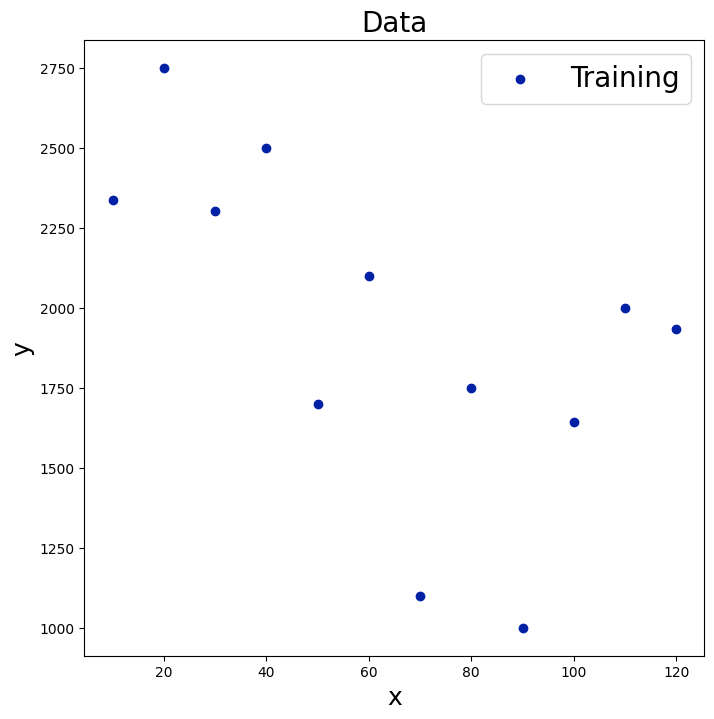

In [14]:
# Create a 1D dataset
X = np.array([10,20,30,40,50,60,70,80,90,100,110,120])
Y = np.array([2337,2750,2301,2500,1700,2100,1100,1750,1000,1642,2000,1932])

# Plot the dataset
fig,ax=plt.subplots( figsize=(8,8) )

plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18)

ax.set_xlabel('x', fontsize=18)
ax.set_ylabel('y', fontsize=18)

ax.set_title('Data',fontsize=20)

ax.scatter(X, Y, color=blue, label='Training')

plt.legend(fontsize=20)

plt.show()

For the sake of simplicity, we will create an object for the implementation of the linear regression model. The object will have the following methods:
    
- **kernel**          : This method will compute the Gaussian kernel for a given set of points.
- **predict**         : This method will compute the prediction for a given set of points.
- **plot_kerneles**   : This method will plot the Gaussian kernels.
- **plot_predictions**: This method will plot the predictions.

In [15]:
# Define a class for Gaussian Kernel Regression
class GaussianKernelRegression1D:
    #
    # Initialization
    #
    def __init__(self, x, y, b):

        self.x = np.asarray(x)
        self.y = np.asarray(y)
        self.b = b
    #
    # Implement the Gaussian Kernel
    #
    def kernel(self, z):

        return ( 1.0/np.sqrt(2.0*np.pi) )*np.exp(-0.5*z*z)
    #
    # Calculate weights and return prediction
    #
    def predict(self, X):

        kernels = [self.kernel( (xi-X)/self.b ) for xi in self.x]
        weights = [kernel/np.sum(kernels) for kernel in kernels]

        return np.dot(weights, self.y)
    #
    # Visualize the kernels
    #
    def plot_kernels(self, points=100):

        plt.figure( figsize = (12,6) )

        plt.title('Kernel', fontsize=20)

        plt.ylabel(r'Kernel Weights $w_i$', fontsize=18)
        plt.xlabel('x', fontsize=18)

        for xi in self.x:
            x_normal = np.linspace(xi - 3.0*self.b, xi + 3.0*self.b, num=points)
            y_normal = norm.pdf(x_normal, xi, self.b)

            plt.plot(x_normal, y_normal, label=r'Kernel at $x_i$={}'.format(xi))
            
        plt.legend(fontsize=14)
    #
    # Visualize the predictions
    #
    def plot_predictions(self, X, points=100):

        max_y = 0

        plt.figure( figsize = (12,6) )

        plt.title('Prediction', fontsize=20)

        plt.ylabel(r'Kernel Weights $w_i$', fontsize=18)
        plt.xlabel('x', fontsize=18)
        
        for xi in self.x:
            x_normal = np.linspace(xi - 3.0*self.b, xi + 3.0*self.b, num=points)
            y_normal = norm.pdf(x_normal, xi, self.b)

            max_y = max(max(y_normal), max_y)

            plt.plot(x_normal, y_normal, label=r'Kernel at $x_i$={}'.format(xi))
            
        plt.plot([X,X], [0, max_y], 'k-', lw=2, dashes=[2, 2])
        
        plt.legend(fontsize=14)

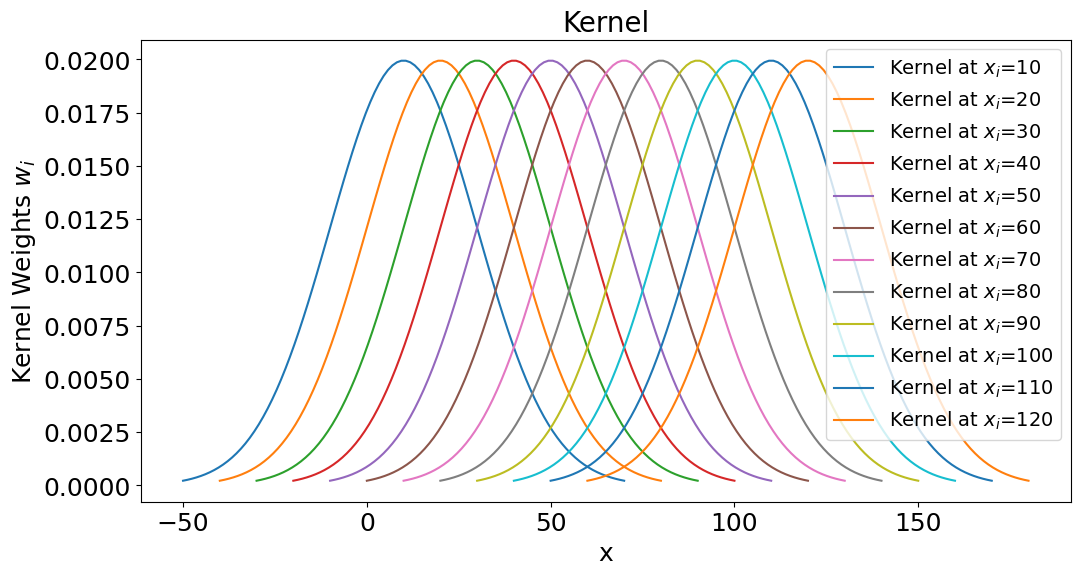

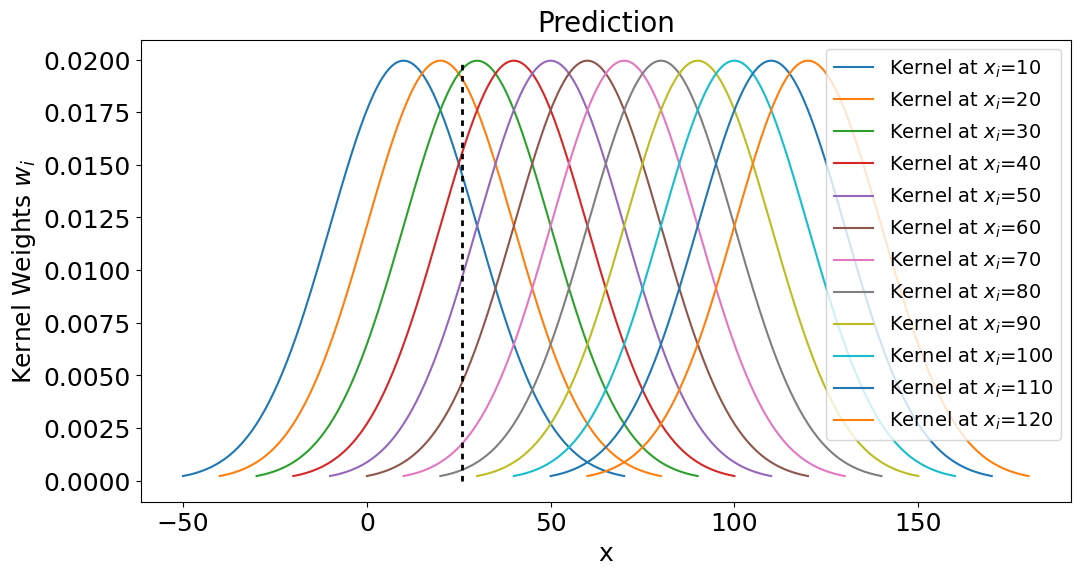

In [16]:
# Set the width of the Gaussian kernel
b = 20

# Create an instance of the GaussianKernelRegression class
gaussian_kernel_regression = GaussianKernelRegression1D(X, Y, b)
gaussian_kernel_regression.plot_kernels(points=100)

# Prediction for test x
x = 26.0
gaussian_kernel_regression.plot_predictions(x, points=200)

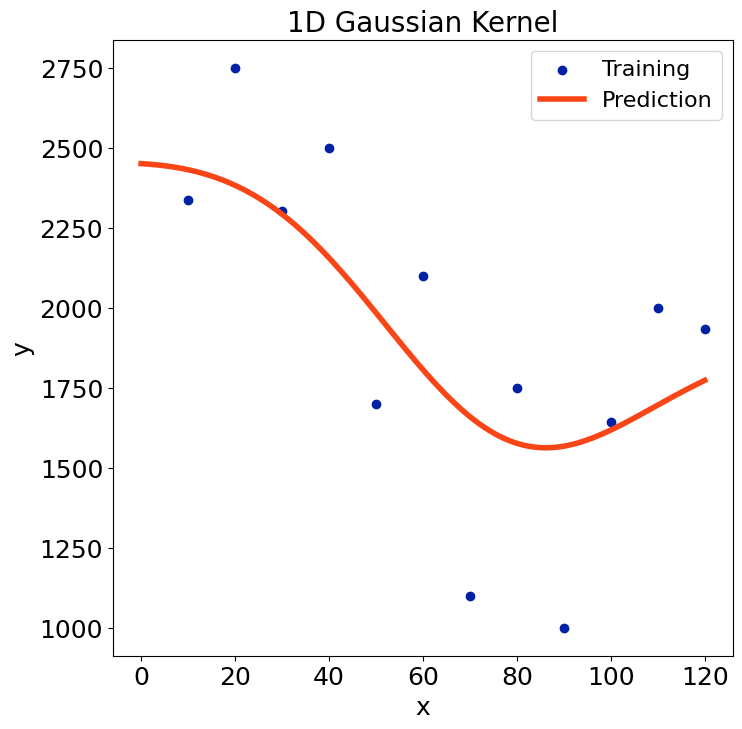

In [17]:
# Visualize the 1-dimensional prediction
xlist = np.linspace(0, 120, 240)
ylist = np.array([gaussian_kernel_regression.predict(x) for x in xlist])

fig,ax = plt.subplots( figsize=(8,8) )

ax.set_title('1D Gaussian Kernel',fontsize=20)

ax.set_xlabel('x',fontsize=18)
ax.set_ylabel('y',fontsize=18)

ax.scatter(X, Y,      color=blue, label='Training')
ax.plot(xlist, ylist, color=orange, lw=4, label='Prediction')

plt.legend(fontsize=16)

plt.show()

### 2.2 N-dimensional regression

For $N$-dimenisonal inputs, we need to calculate the kernels with the Euclidean metric instead.
$$
k(x, x_i) = \frac{1}{\sqrt{2\,\pi}} \exp \left ( - \frac{\|{\bf x}-{\bf x}_i\|^2}{2\,b^2} \right ).
$$

Once again, we will create an object for the implementation of the linear regression model. The object will have the following methods:
    
- **kernel**          : This method will compute the Gaussian kernel for a given set of points.
- **predict**         : This method will compute the prediction for a given set of points.
- **plot_kerneles**   : This method will plot the Gaussian kernels.

In [18]:
class GaussianKernelRegressionND:
    #
    # Initialization
    #
    def __init__(self, x, y, b):

        self.x = np.asarray(x)
        self.y = np.asarray(y)
        self.b = b
    #
    # Implement the Gaussian Kernel
    #
    def gaussian_kernel(self, z):

        return (1.0/np.sqrt(2.0*np.pi))*np.exp(-0.5*z*z)
    #
    # Calculate weights and return prediction
    #
    def predict(self, X):

        kernels = [self.gaussian_kernel( ( np.linalg.norm(xi-X) )/self.b ) for xi in self.x]
        weights = [(kernel/np.sum(kernels)) for kernel in kernels]

        weights = np.asarray(weights)

        return np.dot(weights.T, self.y)
    #
    # Visualize the kernels
    #
    def plot_kernels(self, points=100):
        zsum = np.zeros( (points,points) )

        plt.figure(figsize = (14,8))

        ax = plt.axes(projection = '3d')

        plt.rc('xtick', labelsize=14) 
        plt.rc('ytick', labelsize=14)

        ax.set_ylabel('y', fontsize=14)
        ax.set_xlabel('x', fontsize=14)
        ax.set_zlabel(r'Kernel Weights $w_i$', labelpad=10, fontsize=14)

        for xi in self.x:
            x, y  = np.mgrid[0:points:complex(0.0, points), 0:points:complex(0.0, points)]
            xy    = np.column_stack([x.flat, y.flat])
            z     = multivariate_normal.pdf(xy, mean=xi, cov=self.b)
            z     = z.reshape(x.shape)
            zsum += z

        ax.plot_surface(x, y, zsum, cmap=plt.cm.inferno)

        m = plt.cm.ScalarMappable(cmap=plt.cm.inferno)
        m.set_array(zsum)
        
        plt.colorbar(m, ax=ax, shrink=0.5)

        plt.show()

In [19]:
# Create a reference function to use for machine learning
def reference_function_3d(x=None, y=None, mesh=False):
    
    if mesh: x, y = np.meshgrid(x, y)

    z = ( x * np.exp(-x**2 - y**2) )

    if mesh: return x, y, z
    
    else: return z

# Generate a grid of points for a 3D function
points  = np.linspace(-2, 2, 51)

x, y, z = reference_function_3d(x=points, y=points, mesh=True)

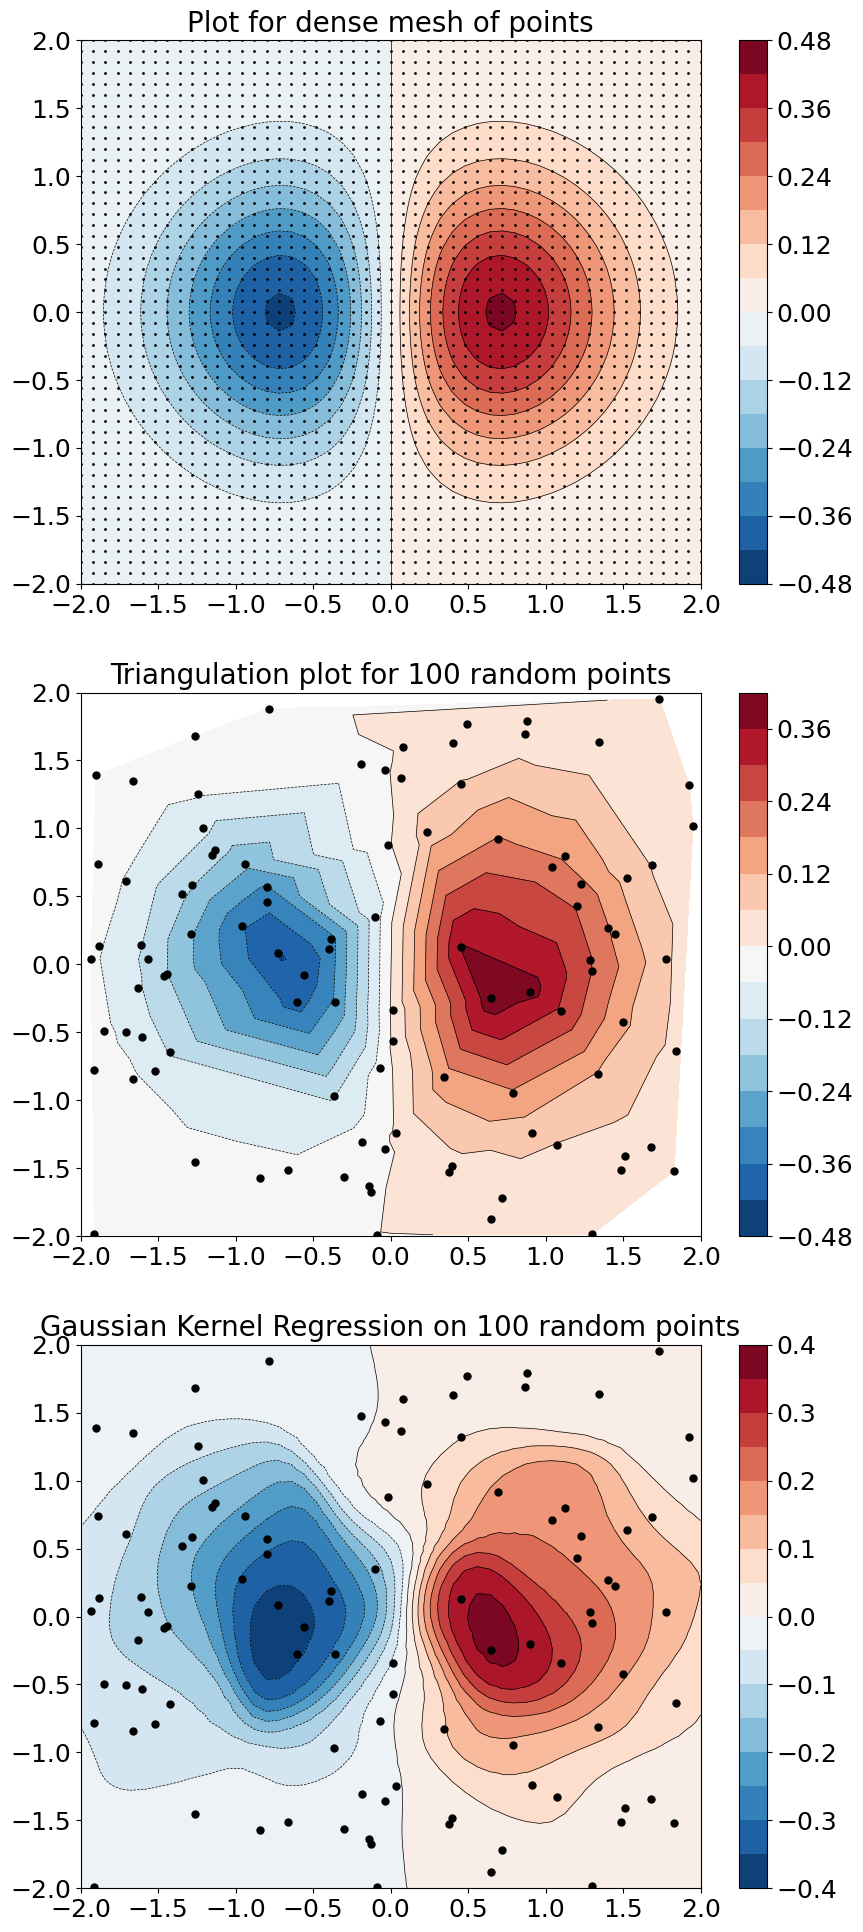

In [20]:
# Create a seed for reproducibility
np.random.seed(23971)
number_of_points = 100

# Width of the Gaussian kernel
b = 0.25

x_random = np.random.uniform(-2, 2, number_of_points)
y_random = np.random.uniform(-2, 2, number_of_points)

# Plot function using a dense regular mesh
fig, (ax1, ax2, ax3) = plt.subplots( nrows=3, figsize=(10, 24) )

plt.subplots_adjust(hspace=0.2)

plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18)

ax1.set_title('Plot for dense mesh of points', fontsize=20)
ax2.set_title(f'Triangulation plot for '
              f'{number_of_points} random points', fontsize=20)
ax3.set_title('Gaussian Kernel Regression on '
              f'{number_of_points} random points', fontsize=20)

ax1.set(xlim=(-2, 2), ylim=(-2, 2))
ax2.set(xlim=(-2, 2), ylim=(-2, 2))
ax3.set(xlim=(-2, 2), ylim=(-2, 2))

# Dense mesh of points
ax1.contour(x, y, z, levels=14, linewidths=0.5, colors='k')

contour_ax1 = ax1.contourf(x, y, z, levels=14, cmap="RdBu_r")

fig.colorbar(contour_ax1, ax=ax1)

ax1.plot(x, y, 'ko', ms=1)

# Triangulation plot for random points
X_train = np.vstack((x_random, y_random)).T
Y_train = reference_function_3d(x_random, y_random)

ax2.tricontour(x_random, y_random, Y_train, levels=14, linewidths=0.5, colors='k')
contour_ax2 = ax2.tricontourf(x_random, y_random, Y_train, levels=14, cmap="RdBu_r")

fig.colorbar(contour_ax2, ax=ax2)

ax2.plot(x_random, y_random, 'ko', ms=5)

# Train Gaussian Kernel Regression on the random points
gaussian_kernel_regression = GaussianKernelRegressionND(X_train, Y_train, b)

x_flat = x.flatten()
y_flat = y.flatten()

z_flat = [gaussian_kernel_regression.predict( [x_val, y_val] )
          for  x_val, y_val in zip(x_flat, y_flat)]

ax3.tricontour(x_flat, y_flat, z_flat, levels=14, linewidths=0.5, colors='k')
contour_ax3 = ax3.tricontourf(x_flat, y_flat, z_flat, levels=14, cmap="RdBu_r")

fig.colorbar(contour_ax3, ax=ax3)
ax3.plot(x_random, y_random, 'ko', ms=5)

plt.show()

> ### Assignment
>
> How is the training affected by different choices of $b$?

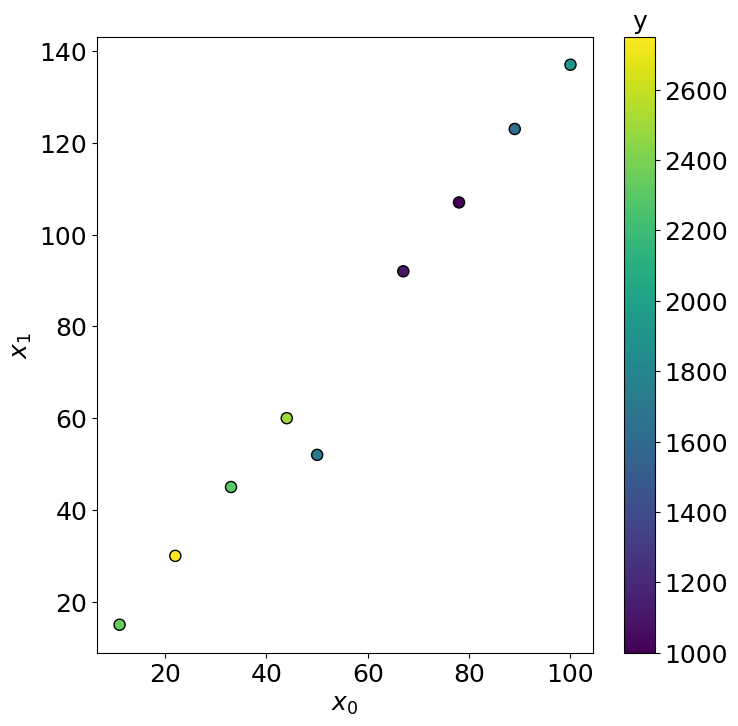

In [21]:
# Define a different set of points
X = np.array([[ 11, 15],
              [ 22, 30],
              [ 33, 45],
              [ 44, 60],
              [ 50, 52],
              [ 67, 92],
              [ 78,107],
              [ 89,123],
              [100,137]])

Y = np.array([2337,2750,2301,2500,1700,1100,1000,1642,1932])

# Plot this new data set
fig, ax = plt.subplots( figsize = (8,8) )

scatter = ax.scatter(X[:,0], X[:,1], c=Y, s=64, edgecolors='k', cmap=plt.cm.viridis)

cbar = fig.colorbar(scatter, ax=ax)

ax.set_xlabel(r'$x_0$', fontsize=18)
ax.set_ylabel(r'$x_1$', fontsize=18)

cbar.ax.set_title('y', fontsize=18)

plt.show()

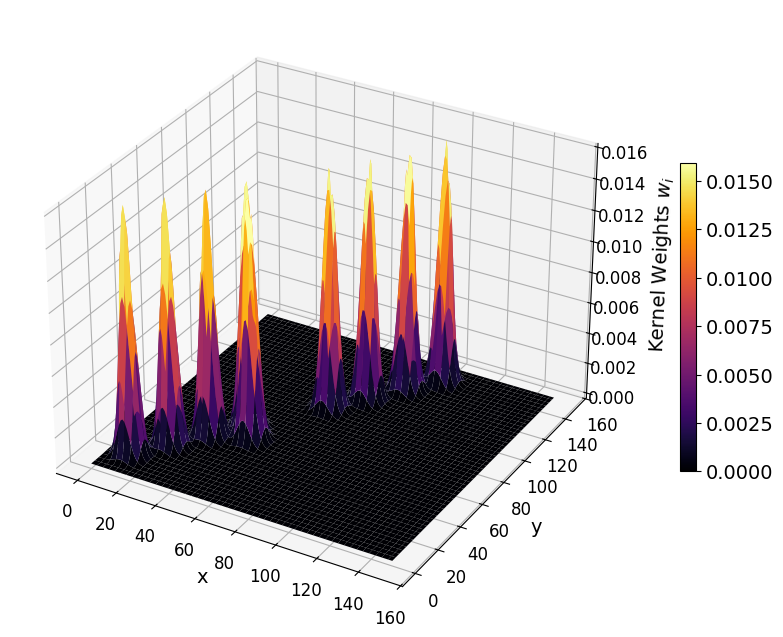

In [22]:
# Set the width of the Gaussian kernel
b = 10

# Create an instance of the object
gaussian_kernel_regression = GaussianKernelRegressionND(X, Y, b)

plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

gaussian_kernel_regression.plot_kernels(points=150)

> ### Assignment
>
> How are the weights modified for different values of the bandwidth parameter $b$?

## 3. Kernel Ridge Regression (KRR)

This method uses the kernel to transform our dataset to the kernel space and then performs a linear regression in kernel-space. Therefore, one should always **choose the appropriate kernel for a problem**. Here, we will be using using a polynomial kernel for two vectors (two points in our one-dimensional example) ${\bf x}_1$ and ${\bf x}_2$ that is given by
$$
K({\bf x}_1, {\bf x}_2) = \left[ \gamma ({\bf x}_1^\mathrm{T}\, {\bf x}_2) + c \right]^d,
$$
where $\gamma$ is the kernel coefficient, $c$ is the independent term and $d$ is the degree of the polynomial. In this case, $\gamma$ and $c$ play a minor role, and their default value of 1.0 is adequate, so we will only focus on optimizing the polynomial degree $d$.

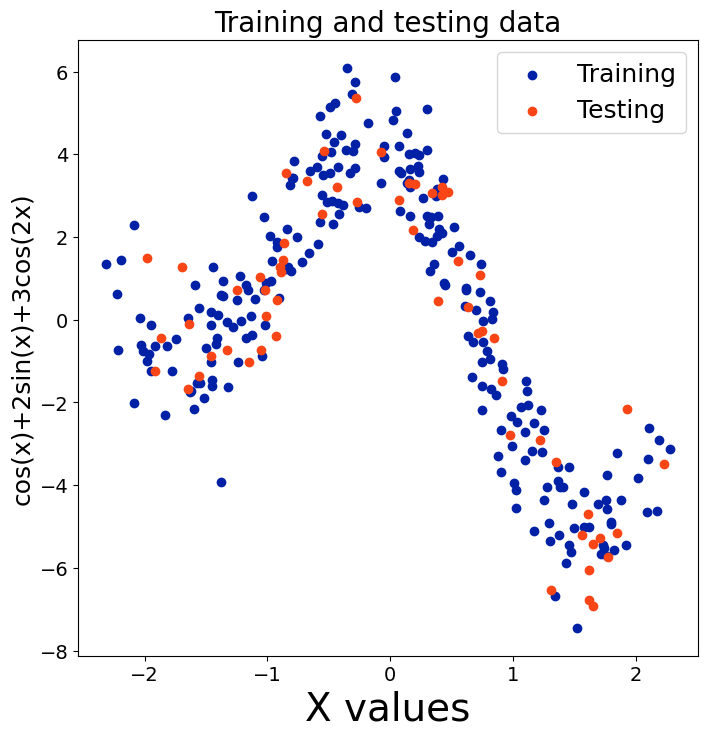

In [23]:
# Create a seed for reproducibility
np.random.seed(seed=5)

data_points = 300
test_points = 1001

# Generate a data set for machine learning
x = np.linspace(-2, 2, num=data_points) + \
    np.random.normal(0.0, 0.3, data_points)
y = np.cos(x) - 2*np.sin(x) + 3*np.cos(x*2) + \
    np.random.normal(0.0, 1.0, data_points)

# Create list with points within the range of the dataset
x_pred = np.linspace(np.amin(x), np.amax(x), num=test_points, endpoint=True)
x_pred = np.array(x_pred).reshape(-1, 1)

# Split the dataset into 80% for training and 20% for testing
x = x.reshape( (x.size,1) )
x_train,x_test,y_train,y_test = train_test_split(x, y, train_size=0.8, shuffle=True)

# Plot the training and testing dataset
fig,ax=plt.subplots( figsize=(8,8) )

ax.set_title('Training and testing data',fontsize=20)

ax.set_xlabel('X values',fontsize=28)
ax.set_ylabel('cos(x)+2sin(x)+3cos(2x)',fontsize=18)

ax.scatter(x_train, y_train, color=blue, marker="o", label='Training')
ax.scatter(x_test,  y_test,  color=orange, marker="o", label='Testing')

plt.legend(loc='best', fontsize=18)
plt.show()

In [24]:
# Create a function to plot and compare results
def plot_comparison(degrees=None, regularization=None, reg_degree=4, rows=2, cols=2):

    # Create lists to store results
    y_pred = []

    training_rmse = []
    testing_rmse  = []

    training_predictions = []
    testing_predictions  = []

    # Shape of the plot
    #rows, cols = 2, 2

    loop_vector = degrees if degrees is not None else regularization

    for choice in loop_vector:
        
        if degrees is not None:
            kernel_ridge_regression = KernelRidge(alpha=1.0,
                kernel='polynomial',
                degree=choice)
            
        if regularization is not None:
            kernel_ridge_regression = KernelRidge(alpha=choice,
                kernel='polynomial',
                degree=reg_degree)
            
        kernel_ridge_regression.fit(x_train, y_train)

        y_pred.append( kernel_ridge_regression.predict(x_pred) )

        pred_y_train = kernel_ridge_regression.predict(x_train)
        pred_y_test  = kernel_ridge_regression.predict(x_test)
        
        # Calculate training and testing errors
        training_predictions.append(pred_y_train)

        mean_error = np.sqrt(mean_squared_error(y_train, pred_y_train))
        training_rmse.append(mean_error)

        testing_predictions.append(pred_y_test)
        mean_error = np.sqrt(mean_squared_error(y_test, pred_y_test))
        testing_rmse.append(mean_error)

    # Plot the results for each polynomial degree
    fig, axs = plt.subplots( rows, cols, figsize=(12,12) )

    for ax in axs.flat:
        ax.set_xlabel('x', fontsize=18)
        ax.set_ylabel('y', fontsize=18)

        ax.label_outer()

        ax.scatter(x_train, y_train, color=blue, marker='o', label='Training')
        ax.scatter(x_test,  y_test,  color=orange, marker='o', label='Testing')

    idx = 0
    for row in range(rows):
        for col in range(cols):
            
            if degrees is not None:
                title_string = r'$d$ = {:2d}'.format( degrees[idx] )
                
            if regularization is not None:
                title_string = r'$\alpha$ = {:.0e}'.format( regularization[idx] )

            axs[row,col].set_title(title_string, fontsize=20)

            axs[row,col].plot(x_pred, y_pred[idx], color='black', lw=4)

            axs[row,col].annotate(f'Training RMSE = {training_rmse[idx]:.2f}',
                    xy=(0.2,0.2), xycoords='axes fraction', fontsize=14)
            
            axs[row,col].annotate(f'Testing RMSE = {testing_rmse[idx]:.2f}',
                    xy=(0.2,0.1), xycoords='axes fraction', fontsize=14)

            idx += 1

    plt.show()

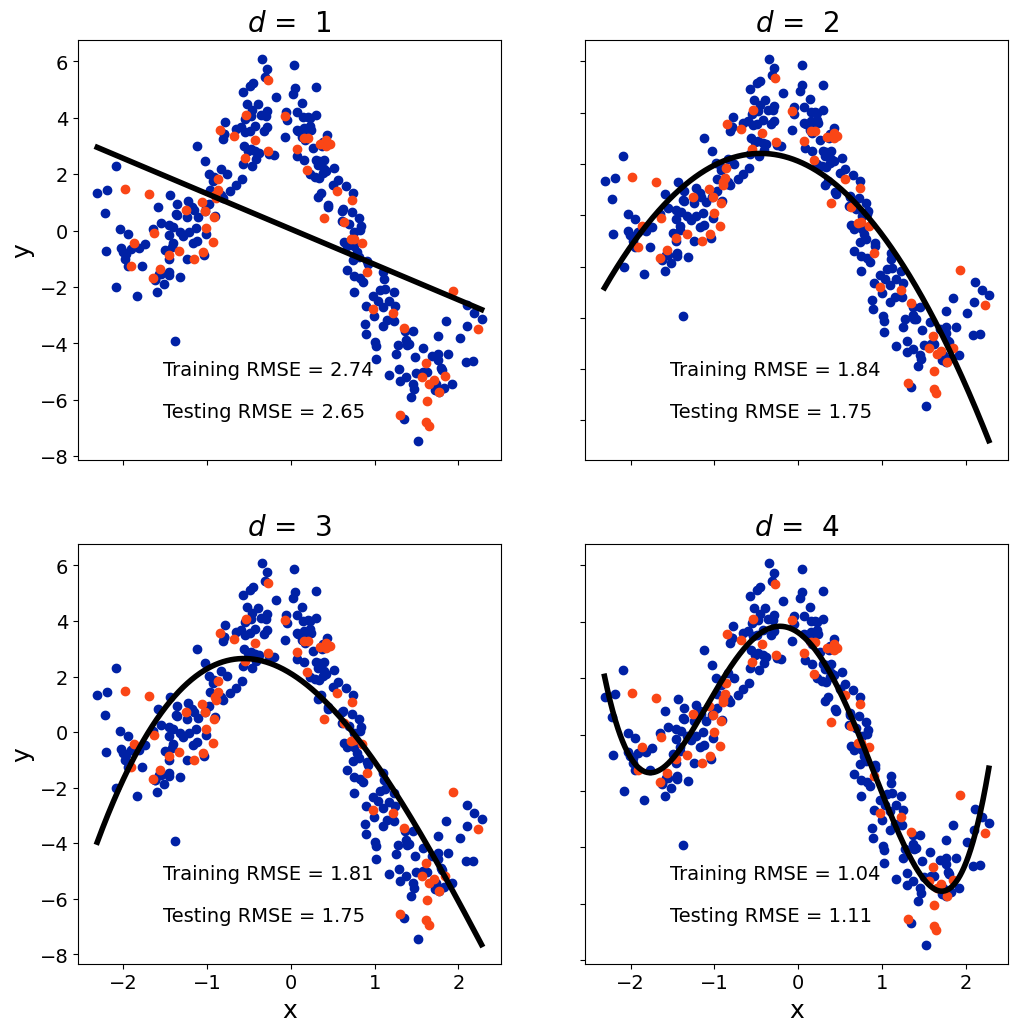

In [25]:
plot_comparison( degrees=[1, 2, 3, 4] )

> ### Assignment
>
> What happens to the RMSE in both training and testing as the degree of the polynomial increases?

### 3.1 Regularization parameter

The regularization paremeter, $\alpha$, should also be optimized. It controls the conditioning of the problem, and larger $\alpha$ values result into results that are more “general” and ignore the peculiarities of the problem. Larger values of $\alpha$ allow to ignore noise in the system, but this might result into the model being blind to actual trends of the data.

If we perform our kernel ridge regression for different $\alpha$ values, we can see its effect, as shown below.

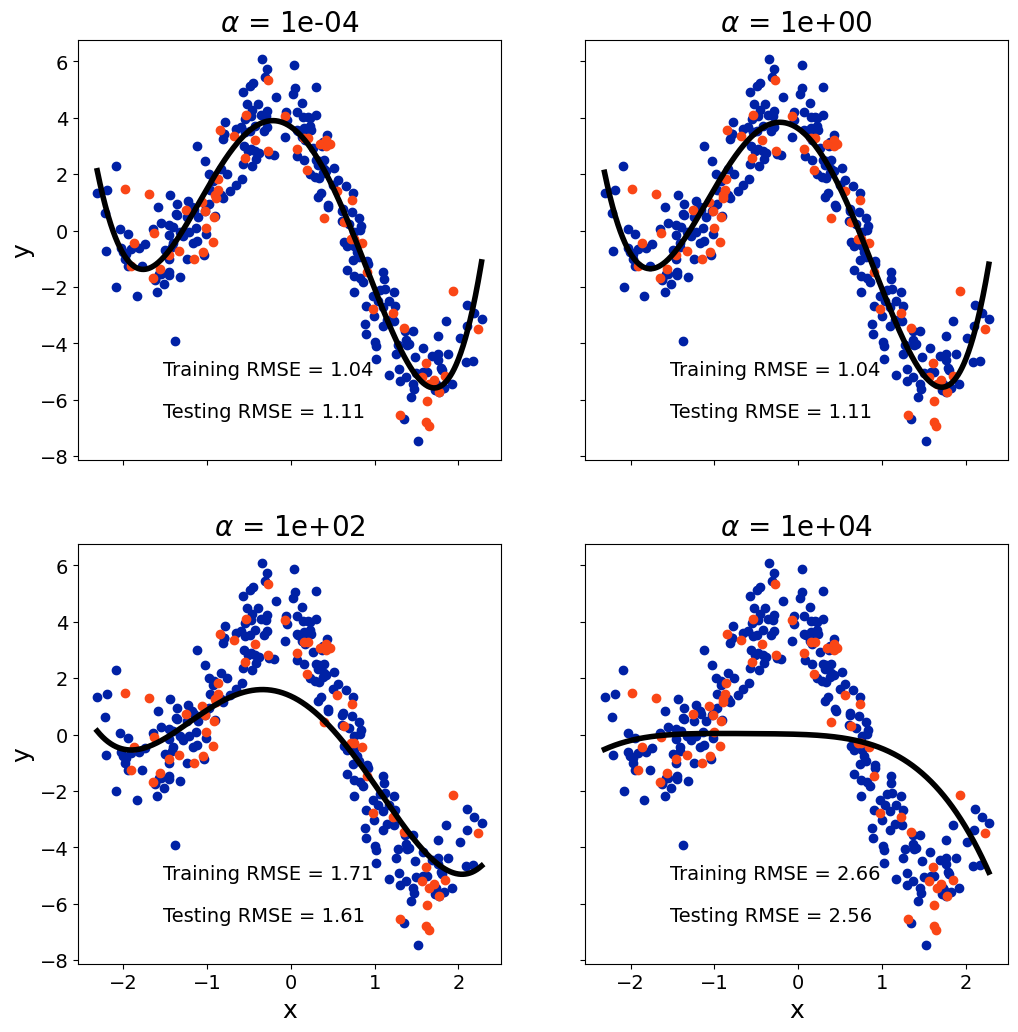

In [26]:
plot_comparison( regularization=[1e-4, 1e0, 1e2, 1e4] )

> ### Assignment
>
> How do the testing RMSEs change as the regularization parameter increases?

> ### Assignment
>
> Optimize the degree for the polynomial kernel and the regularization parameter for the Gaussian kernel. Show your results using a heatmap and plot your best prediction.